# Pricing Asian, Lookback, and Floating-Lookback Options using Monte Carlo Simulation

In [13]:
# Import libraries
import numpy as np
from scipy.stats import norm
from math import log, sqrt,exp
import matplotlib.pyplot as plt

In [14]:
# Pricing a European option. 
# Assuming the cases are done in a risk netural world where risk free rate can be applied for calculation and pricing process.

S0 = 100     # spot price of the underlying stock today
K = 105      # strike at expiry
sigma = 0.25  # volatility
r = 0.02     # risk-free rate
T = 2/12      # years to expiry


In [15]:
def OptionsPricing(S0, K, T, r, sigma, numSteps, numPaths,OPtype,graph):
  paths = np.zeros((numSteps + 1, numPaths))
  Smin=[]
  Smax=[]
  Savg=[]
  St=[]
  puts=[]
  calls=[]
  # dT is the time increment (in years)
  dT = T / numSteps
  
  # Vector of paths will store realizations of the asset price
  # First asset price is the initial price
  paths[0] = [S0] * numPaths

  # Generate paths
  for iPath in range(numPaths): #This is n 
      for iStep in range(numSteps): #this is m
          paths[iStep + 1, iPath] = paths[iStep, iPath] * np.exp((r - 0.5 * sigma ** 2) * dT 
                                                                  + sigma * np.sqrt(dT) * np.random.normal(0,1))
      #Find the values for the path
      Smin.append(np.max(paths[:,iPath],axis=0))
      Smax.append(np.min(paths[:,iPath],axis=0))
      Savg.append(np.mean(paths[:,iPath],axis=0))
      St.append(paths[numSteps,iPath])
      if OPtype==1: #Asian
        PutPayoffT = np.maximum(K - Savg[-1], 0)
        CallPayoffT = np.maximum(Savg[-1] - K, 0)
      if OPtype==2: #Lookback
        PutPayoffT = np.maximum(K - Smin[-1], 0)
        CallPayoffT = np.maximum(Smax[-1] - K, 0)
      if OPtype==3: #Floating lookback 
        PutPayoffT = np.maximum(Smax[-1] - St[-1], 0)
        CallPayoffT = np.maximum(St[-1] - Smin[-1], 0)
      puts.append(PutPayoffT) #add payoff for the put for the path to the list
      calls.append(CallPayoffT) #add payoff for the call for the path to the list

  d = float(np.exp(-r * T))
  parr = (np.array(puts) * d).tolist()
  carr = (np.array(calls) * d).tolist()
  p = np.mean(parr) #average the payoffs over all the paths for put and bring to present
  c = np.mean(carr) #average the payoff over all the paths for call and bring to present
  if graph==True:
     [plt.plot(paths[:,i], linewidth=2) for i in range(numPaths)]
     plt.title('Geometric Random Walk for Option: '+str(numSteps)+' Steps '+str(numPaths)+' Paths ')
     plt.xlabel('Time step(Weeks) in 2 months')
     plt.ylabel('Price of asset $')
     plt.show()
  return c, p
     

## Run the simulation

In [16]:
# Define variable numSteps to be the number of steps for multi-step MC
# numPaths - number of sample paths used in simulations

numSteps = 9; #in reality its more like 8.66 weeks so round up (since has to be a integer)
numPaths = 1000;

In [17]:
#Legend for type of option
# 1 is for Asian Option
# 2 is for Lookback Option
# 3 is for Floating lookback option
OPtype=1
#Implemeting the type of option for pricing the option
callMC_Price, putMC_Price = OptionsPricing(S0, K, T, r, sigma, numSteps, numPaths,OPtype,graph=False)

optiontype=['Asian','Lookback','Floating Lookback']
print('Call Option Price:',optiontype[OPtype-1],' '+ str(callMC_Price))
print('Put Option Price:',optiontype[OPtype-1],' ' + str(putMC_Price))


Call Option Price: Asian  0.7595625246895936
Put Option Price: Asian  5.289332086117248


# Pricing an American Put Option using Monte Carlo Simulation

In [28]:
# Import libraries
import seaborn as sns

In [32]:
# Givens from the question
r = 0.02 # Risk-free rate
S0 = 100 # Underlying price at time 0
sigma = 0.25 # Volatility
K = 105 # Strike price
T = 2/12 # Maturity date in units of years (2 months)
dt = 1/52 # Size of time increment -> will use T/m as dt moving forward to close rounding discrepancy
m = round(T/dt) # Number of time increments, rounded to the nearest whole number for simulation
n = 1000 # Number of paths, question requires sample size of 250 or larger

The below code creates a custom function that performs Monte Carlo simulations given initial stock price, risk-free rate, volatility, maturity date, number of time increments, and number of desired paths.
This was done using a nested for loop where each path is created in the inner loop in list form, and nested into another list on the outer loop to act similarly to a MATLAB array.
Additionally, a plot of the Simulation was created for visualization purposes.
This custom function acts as a pipeline for Monte Carlo Simulations and will be used in another custom function that ties all of the American Put Option pricing computation together.

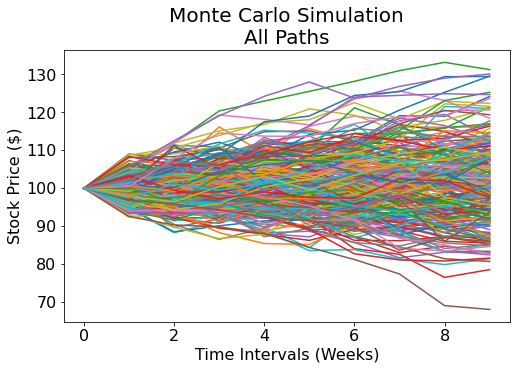

In [19]:
def price_simulations(S0, r, sigma, T, m, n):
    """
    Monte Carlo Simulation for m time increments and n different paths.
    Return a matrix of stock prices with each row as a path and each column as a time increment.
    """
    dt = T/m # Length of time increment (years)
    
    total_paths = []
    for i in range(n):
        path_i = [S0]
        for j in range(m):
            stj = path_i[-1]*np.exp((r-sigma**2/2)*dt + sigma*np.sqrt(dt)*np.random.normal(0,1))
            path_i.append(stj)
        total_paths.append(path_i)
    return total_paths

# Sample Monte Carlo Simulation for Visualization Purposes
total_paths = price_simulations(S0, r, sigma, T, m, n)

# Plotting
plt.figure(figsize = (8, 5))
for i in range(n):
    ax = sns.lineplot(x = range(m+1), y = total_paths[i])
plt.title('Monte Carlo Simulation\nAll Paths', fontsize = 20)
plt.xlabel('Time Intervals (Weeks)', fontsize = 16)
plt.ylabel('Stock Price ($)', fontsize = 16)
ax.xaxis.set_tick_params(labelsize = 16)
ax.yaxis.set_tick_params(labelsize = 16)

The below code is a custom function that determines the Optimal Exercise Points for a single given time. This will be used in another custom function that ties all of the American Put Option pricing computation together inside a loop that will iterate for all time increments, and the Optimal Exercise Points will be stored for each time increment to create an Optimal Exercise Boundary.
This is done through using backwards induction by comparing the payoff of Optimal Exercising at a future time versus exercising at a previous time increment.
This code follows the pseudo-code steps provided in page 15 of "Pricing American Options using Monte Carlo Simulation" by Nairn McWilliams provided in the course. Only the steps relevant to pricing were followed as the question only asked for price, not mean optimal stopping times or confidence intervals.

In [20]:
def opt_exer_bounds(S, P, K, n, thetaj_p1):
    """
    Determines the Optimal Exercise Boundary for a given time.
    Uses backwards induction to determine optimal put pricing at a given time.
    Inputs:
    S = Stock price for all paths at a given time.
    P = Put price for all paths at a given time assuming all paths will exercise in the future
        (compare with exercise today in this function)
    K = Strike price
    n = Number of paths
    thetaj_p1 = Optimal Exercise Boundary for the next time step
    """ 
    SP_pairs = [list(pair) for pair in zip(S, P)]
    previous_P = []

    put_hat = np.mean(P)
    thetaj_hat = thetaj_p1
    for i in range(n):
        if SP_pairs[i][0] <= thetaj_p1:
            put = []
            for j in range(n):
                if SP_pairs[j][0] <= SP_pairs[i][0]:
                    put.append(max(0, K-SP_pairs[j][0]))
                else:
                    put.append(SP_pairs[j][1])
            if np.mean(put) > put_hat:
                put_hat = np.mean(put)
                thetaj_hat = SP_pairs[i][0]
                previous_P = put
    if previous_P == []:
        previous_P = P

    return (previous_P, thetaj_hat)

This is a custom function that ties the other functions together to determine the American Put Option pricing. It begins by performing Monte Carlo Simulation, and then initializes the backwards induction process by determining the stock prices, put prices, and optimal exercise price for all paths at maturity date. Subsequently, the code performs the backward induction process by looping over the second last time increment until time = 0 and every loop uses the custom function directly above. Finally, the function plots the Optimal Exercise Boundary.

In [29]:
def MC_American_put(r, sigma, S0, K, T, m, n):
    """
    Using Monte Carlo Simulation to price an American Put Option.
    Returns the price of an American Put and plots the Optimal Exercise Boundary over time.
    """
    # Perform Monte Carlo Simulation
    total_paths = price_simulations(S0, r, sigma, T, m, n)
    
    # At maturity date
    stock_prices = [total_paths[i][-1] for i in range(n)]
    put_prices = [max(K-stock_prices[i], 0) for i in range(n)]
    thetaj = [0]*(m+1)
    thetaj[-1] = K

    # Backwards induction
    for i in range(m-1, -1, -1):
        put_prices = (np.array(put_prices)*np.exp(-r*T/m)).tolist()
        stock_prices = [row[i] for row in total_paths]
        thetaj_p1 = thetaj[i+1]
        (put_prices, thetaj[i]) = opt_exer_bounds(stock_prices, put_prices, K, n, thetaj_p1)
        
    # Plotting
    plt.figure(figsize = (10, 8))
    ax = sns.lineplot(x = range(len(thetaj)), y = thetaj)
    plt.title('Optimal Exercise Boundary', fontsize = 20)
    plt.xlabel('Time Intervals (Weeks)', fontsize = 16)
    plt.ylabel('Stock Price ($)', fontsize = 16)
    ax.xaxis.set_tick_params(labelsize = 16)
    ax.yaxis.set_tick_params(labelsize = 16)
    
    return np.mean(put_prices)

Price of an American Put Option using Monte Carlo Simulation: $ 7.02


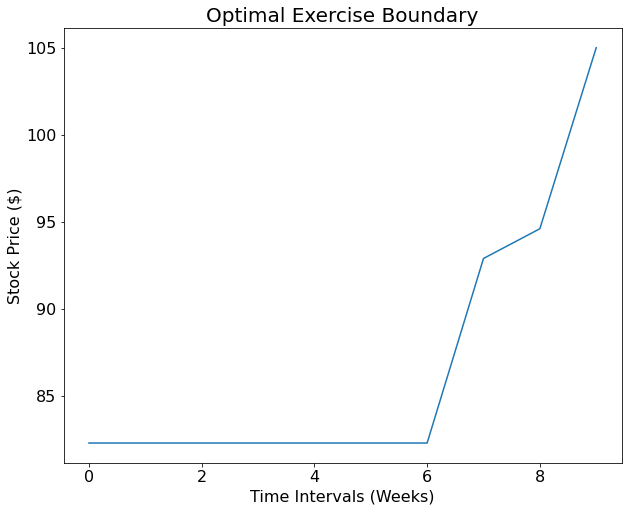

In [35]:
price = MC_American_put(r, sigma, S0, K, T, m, n)
print('Price of an American Put Option using Monte Carlo Simulation: $', np.round(price, 2)) 

# Notes for the Write-Up
## Summary
- In this project, two methods were used to determine pricing for various options contracts. These two methods were Monte Carlo Simulation and the Binomial Lattice Approach.
- The types of options that were priced were Asian call/put, Lookback call/put, Floating lookback call/put, and American put. Where they all had the same underlying parameters with a risk-free rate of 2%, a current stock price of 100 dollars, volatility of 25 percent, no dividend payments, strike price of 105 dollars, maturity date in 2 months, and a unit time interval of 1 week.
- Asian options are a type of exotic option in which payoff depends on the average underlying stock price over the option lifetime rather than the underlying stock price at maturity for regular European options.
- Lookback options have a fixed strike price, but at maturity, the contract owner can look into the history of the underlying price action throughout the option lifetime and choose the most favorable price to exercise at.
- Floating lookback options have to be exercised at the stock price at maturity time, but the strike price can be set to the most favorable price that the underlying asset reached throughout the option lifetime.
- American options are identical to the classical European options in every regard except they also have the ability to exercise prior to maturity.

## Monte Carlo Method
- The Monte Carlo Method is a method derived from Wiener's Process, which was then generalized to become Brownian Motion. Brownian Motion was further generalized by taking the natural logarithm and converting the model from an additive model to a multiplicative model, and assumed Ito's Lemma to become Geometric Brownian Motion.
- The Monte Carlo Method takes the Geometric Brownian Motion formula, and incrementally generates random stock price paths by taking a Markovian assumption (where future stock price only depends on current stock price and does not need to consider historical stock price), and assumes a random walk.
- Monte Carlo theory relies on risk-neutral valuation.
- This method requires the present stock price, risk-free rate, volatility, and a defined incremental time interval in order to function. It begins at the present and takes "random steps" which assumes a log-normal distribution that has a mean of (risk-free rate - volatility^2/2) multiplied by dt and a standard deviation of volatility multiplied by the square root of dt. The random steps each move forward by a time interval of dt until the maturity date of the option is reached. As dt approaches 0, the simulation becomes continuous, however, this project has a dt of 1 week, so the simulations were discrete.
- At least 250 Monte Carlo Simulations were created per option valuation to generate a large enough sample size to more accurately predict options pricing. The option price was taken as the arithmetic mean of the present value of the payoff at all paths.
- Specifically for the American Put Option, an Optimal Exercise Boundary was generated using backwards induction in order to compute the pricing for the American Put Option. To do this, all price actions at all incremental time steps for all possible Monte Carlo paths were considered for early exercise, and how the resulting payoff would compare with exercising later in the future, perhaps at a more "optimal" time. Adjusted for time value of money.

## Lattice Method

## Visualizations and Explanations of Major Functions in the Code
- This was done at every code block.

## Comparison Between the Two Methods and Discussion

## Lessons Learned
- Pricing the ability to exercise options early is very tedious and complicated. At least for the Monte Carlo approach.
- A very large number of Monte Carlo Simulation paths and very small time increments are required to achieve a feasible and consistent Optimal Exercise Boundary, which may cause errors due to lack of memory, and/or significantly long run times.